In [207]:
import numpy as np
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

In [210]:
with open("../data/mini_gm_public_v0.1.p", "rb") as file:
    data = np.load(file, allow_pickle=True)

In [211]:
type(data)

dict

In [221]:
dict = {
    'syndrome_id':[],
    'subject_id':[],
    'image_id':[]
}
len_emb = 320
embeddings = [f'd_{i+1}' for i in range(len_emb)]
dict.update({i:[] for i in embeddings})

emb = []
for i in data.keys():
    d = data[i]
    for j in d.keys():
        e = d[j]
        for k in e.keys():
            dict['syndrome_id'].append(i)
            dict['subject_id'].append(j)
            dict['image_id'].append(k)
            emb.append(e[k])
emb = np.array(emb)
for i in range(len_emb):
    dict[embeddings[i]] = emb[:,i]

df = pd.DataFrame(dict)

In [201]:
df.describe().T.sort_values('std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
d_297,1116.0,-0.065015,1.577003,-7.986729,-1.075919,0.040523,1.022425,4.255168
d_260,1116.0,-0.315137,1.405771,-4.828587,-1.266311,-0.346136,0.680840,3.597312
d_304,1116.0,0.079092,1.389738,-5.531175,-0.805256,0.091585,1.044061,4.683500
d_193,1116.0,0.097242,1.387714,-3.933583,-0.822143,0.111482,1.027335,5.001272
d_189,1116.0,0.245080,1.375595,-3.615786,-0.664898,0.186226,1.116138,5.191270
...,...,...,...,...,...,...,...,...
d_139,1116.0,0.308456,1.017479,-2.937943,-0.409854,0.275990,1.016097,3.829202
d_190,1116.0,0.128127,1.007568,-2.879861,-0.521117,0.092798,0.801663,4.003929
d_217,1116.0,0.283260,0.992883,-3.008166,-0.395446,0.321383,0.957681,3.964838
d_318,1116.0,-0.005239,0.990698,-3.288884,-0.666347,0.041906,0.679501,2.797920


In [202]:
null_sum = {'emb':[], 'sum_null':[]}
for i in embeddings:
    null_sum['emb'].append(i)
    null_sum['sum_null'].append(df[i].isnull().sum())
df_null = pd.DataFrame(null_sum)
df_null.sort_values('sum_null', ascending=False).T


,280,281,282,283,284,285,286,287,272,273,...,14,15,0,1,2,3,4,5,6,7
emb,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_273,d_274,...,d_15,d_16,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8
sum_null,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
#shapiro test to check normality of embedding data
shapiro_test = {'emb':[], 'stat':[], 'p':[], 'is_normal':[]}
for i in embeddings:
    shapiro_test['emb'].append(i)
    stat, p = shapiro(df[i])
    shapiro_test['stat'].append(stat)
    shapiro_test['p'].append(p)
    if p < 0.05:
        shapiro_test['is_normal'].append(False)
    else:
        shapiro_test['is_normal'].append(True)
df_shapiro = pd.DataFrame(shapiro_test)
df_shapiro.sort_values('p', ascending=True).T

,296,254,46,48,253,188,149,286,283,273,...,301,39,228,263,203,100,135,295,29,79
emb,d_297,d_255,d_47,d_49,d_254,d_189,d_150,d_287,d_284,d_274,...,d_302,d_40,d_229,d_264,d_204,d_101,d_136,d_296,d_30,d_80
stat,0.987735,0.98977,0.990164,0.992058,0.993112,0.99323,0.994094,0.994366,0.994372,0.994712,...,0.999162,0.999165,0.999185,0.999205,0.99921,0.999222,0.999234,0.999316,0.999359,0.9994
p,0.0,0.000001,0.000001,0.00001,0.000048,0.000057,0.000216,0.000334,0.000337,0.000587,...,0.909659,0.910788,0.92018,0.928853,0.931148,0.935957,0.940651,0.96735,0.977546,0.984992
is_normal,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


<Axes: ylabel='is_normal'>

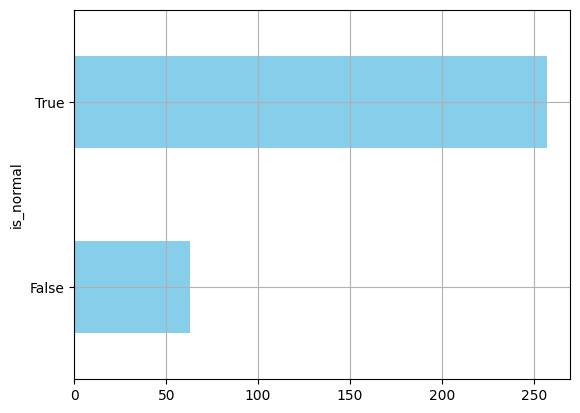

In [204]:
df_shapiro['is_normal'].value_counts().sort_values().plot(kind='barh', color='skyblue',grid=True)

In [127]:
df_shapiro['is_normal'].value_counts()/320

is_normal
True     0.803125
False    0.196875
Name: count, dtype: float64

In [135]:
# Since most of embeddings are normal, we will scale the data using standard scaler
from sklearn.preprocessing import StandardScaler
scaled_df = df.copy()
scaler = StandardScaler()
scaled_df[embeddings] = scaler.fit_transform(df[embeddings])

In [152]:
# import T-SNE and PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [158]:
emb_tsne = {'c_1':[], 'c_2':[], 'syndrome_id':[]}
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(scaled_df[embeddings])
emb_tsne['c_1'] = embeddings_tsne[:,0]
emb_tsne['c_2'] = embeddings_tsne[:,1]
emb_tsne['syndrome_id'] = df['syndrome_id']
df_tsne = pd.DataFrame(emb_tsne)

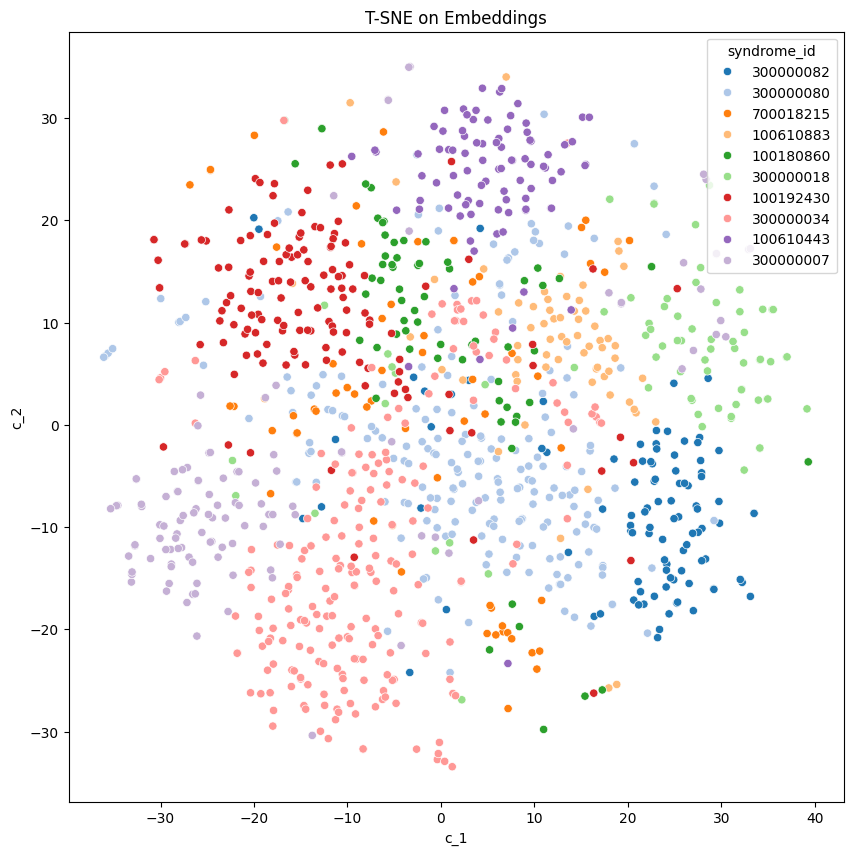

In [160]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_tsne, x='c_1', y='c_2', hue='syndrome_id', palette='tab20')
plt.title('T-SNE on Embeddings')
plt.show()

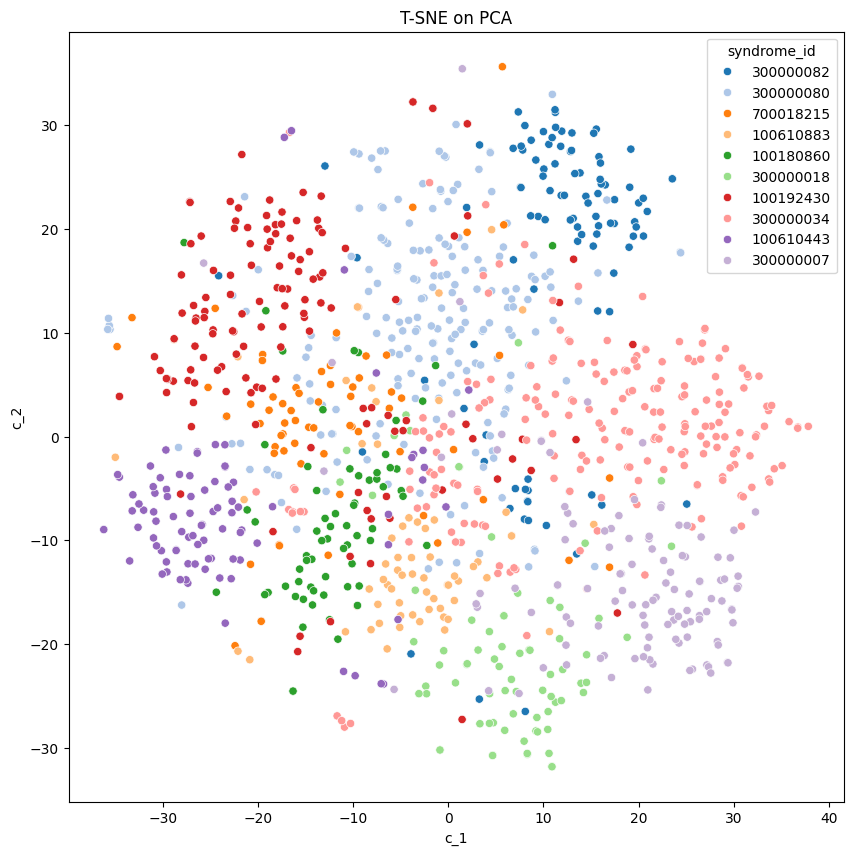

In [164]:
#apply PCA to reduce the dimensionality of the data for 40 components and then apply T-SNE to visualize the data in 2D
emb_tsne = {'c_1':[], 'c_2':[], 'syndrome_id':[]}
pca = PCA(n_components=40)
embeddings_pca = pca.fit_transform(scaled_df[embeddings])
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)
emb_tsne['c_1'] = embeddings_tsne[:,0]
emb_tsne['c_2'] = embeddings_tsne[:,1]
emb_tsne['syndrome_id'] = df['syndrome_id']
df_tsne = pd.DataFrame(emb_tsne)
# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_tsne, x='c_1', y='c_2', hue='syndrome_id', palette='tab20')
plt.title('T-SNE on PCA')
plt.show()

<Axes: xlabel='syndrome_id'>

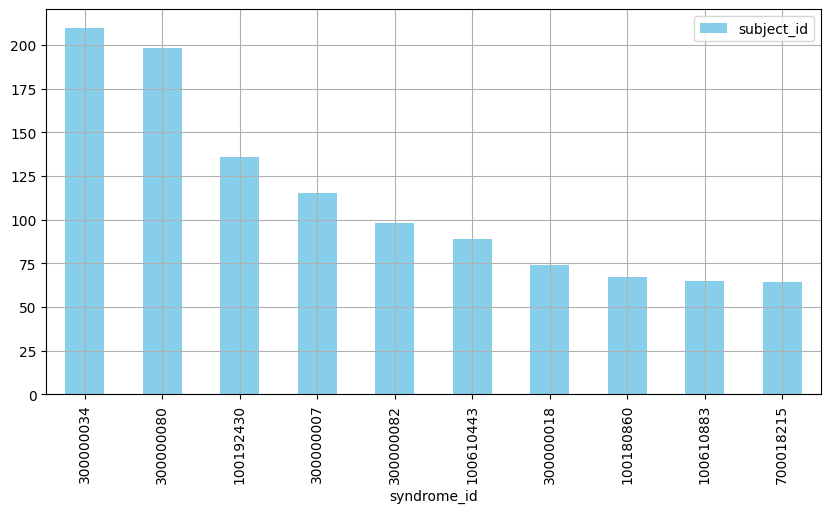

In [205]:
df[['syndrome_id', 'subject_id']].groupby('syndrome_id').count().sort_values('subject_id', ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue', grid=True)

<Axes: xlabel='syndrome_id'>

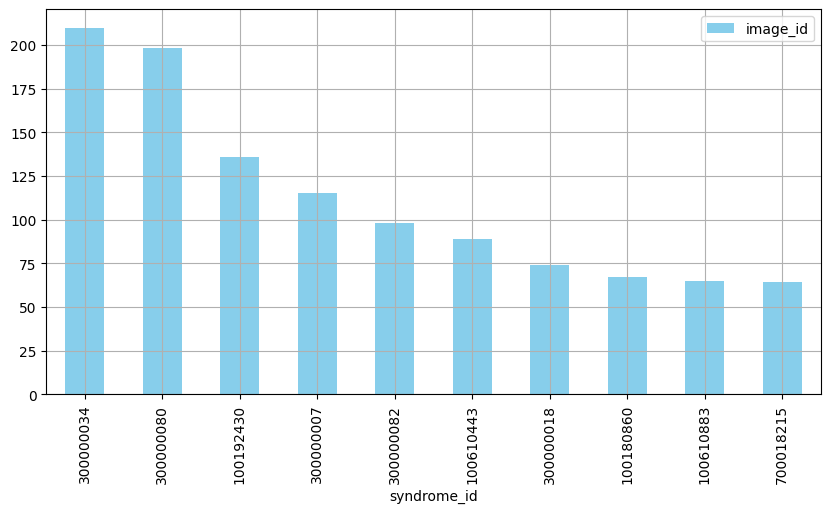

In [206]:
df[['syndrome_id', 'image_id']].groupby('syndrome_id').count().sort_values('image_id', ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue', grid=True)

In [167]:
df[['syndrome_id','subject_id']].corr()

,syndrome_id,subject_id
syndrome_id,1.000000,0.065947
subject_id,0.065947,1.000000


In [ ]:
import scipy.stats as stats
import pandas as pd

# Create a contingency table
contingency_table = pd.crosstab(df['subject_id'], df['syndrome_id'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 10044.0, p-value: 6.90915801390292e-31


In [176]:
df['subject_id'].nunique()

941

In [189]:
# select subject_id that repeats more than 1 time
df[df['subject_id'].duplicated()].sort_values('subject_id')

,syndrome_id,subject_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320
1024,300000007,10026,-1.252701,-1.058386,0.031085,0.635603,-1.012115,0.433484,1.082414,-0.962934,...,-0.234469,-0.693513,-2.739889,0.026378,-0.784868,-1.143094,0.676417,0.989659,-1.983654,0.952222
1022,300000007,10026,1.933608,-0.781257,0.492417,0.298240,1.980298,0.555048,-0.067159,-1.118373,...,1.039206,-0.532742,-2.259973,-0.013982,-1.370827,-2.559791,1.881909,-1.031132,-0.211193,1.235980
1023,300000007,10026,0.610211,-0.723608,-0.577170,-1.143496,0.197557,-0.070701,-0.311038,0.398285,...,2.045701,-1.469859,-2.774253,-1.384524,2.003613,0.693184,-0.801563,-0.763704,-1.309328,-1.032924
1020,300000007,10029,-0.170574,0.273980,-0.514073,1.303375,1.218014,-0.433680,-1.728799,0.979884,...,0.334804,-1.244526,0.178790,-2.763360,0.889621,-0.631325,0.150091,0.374397,-1.293792,0.357322
1100,300000007,10031,1.258903,0.531293,-0.542135,0.005944,-0.158293,0.339747,-2.371696,1.273551,...,0.622431,-0.850220,-0.398145,-1.310150,0.957648,-1.158529,-0.383433,0.435491,-0.846525,-0.983183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,300000018,9840,0.531859,-0.225116,-0.787121,1.012098,0.473333,-0.729384,0.750980,0.463056,...,0.292306,-0.602105,0.195972,-0.394818,-0.264965,1.420082,0.502010,0.122401,-0.422830,0.807584
782,300000034,9860,-1.286489,-0.254599,-0.031511,1.800821,1.727266,1.430176,-2.204941,-1.033242,...,1.079588,0.032082,-3.548060,3.084290,0.760335,-1.211336,1.673081,-0.836177,-0.234338,0.186876
464,100180860,9904,-0.012164,-1.393845,0.650827,-0.397346,-0.486148,1.306928,-0.250482,-0.615056,...,1.092073,-1.051849,-0.121063,-1.547521,-0.014188,1.630366,-1.550227,-1.884550,1.402188,-0.134252
463,100180860,9904,1.106272,0.023208,-1.051423,-0.982372,1.381088,0.332934,-0.297916,-0.238854,...,1.436250,-0.352490,0.931176,-1.023579,0.725888,-0.505897,-1.477114,-0.683275,0.613863,-0.636645


In [190]:
# Create a contingency table
df2 = df.drop_duplicates(subset='subject_id')
contingency_table = pd.crosstab(df2['subject_id'], df2['syndrome_id'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 8469.0, p-value: 0.47038978958917615


<Axes: xlabel='syndrome_id'>

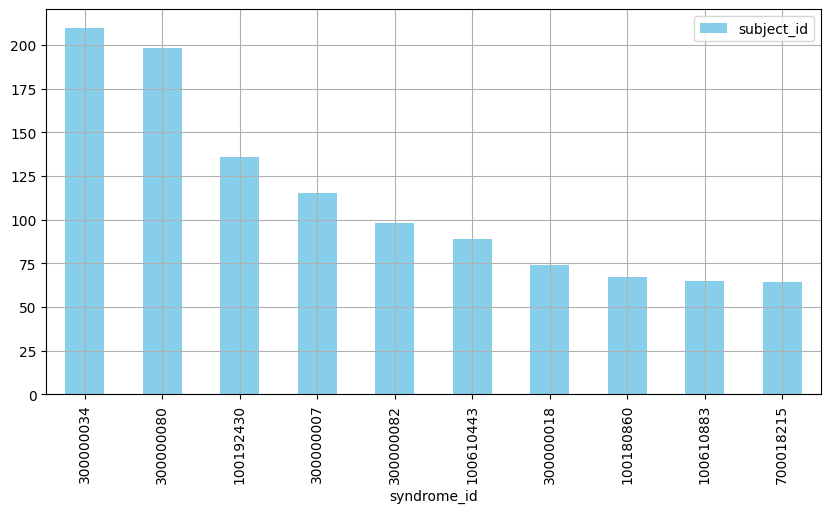

In [192]:
# See how many subject_id are in each syndrome_id
df[['syndrome_id', 'subject_id']].groupby('syndrome_id').count().sort_values('subject_id', ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue', grid=True)

<Axes: >

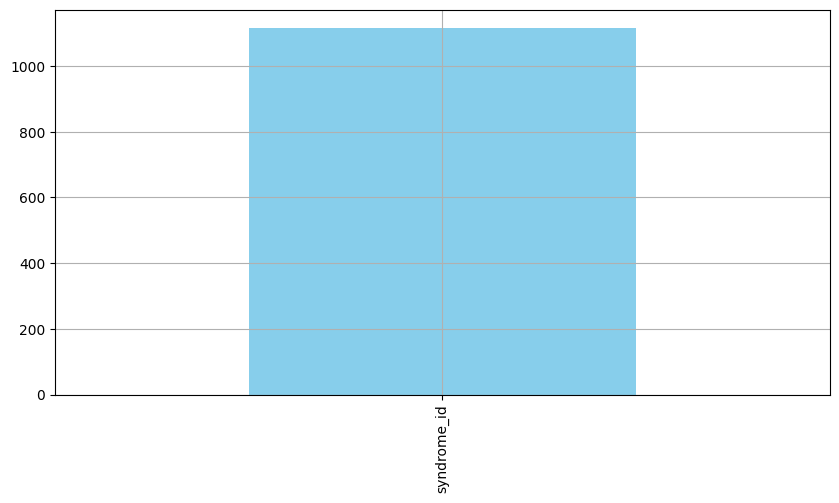

In [ ]:

df[['syndrome_id', index]].count().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue', grid=True)